In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Random Forest
import numpy as np
import pandas as pd
import re
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from pygments.lexers import CLexer
from pygments import lex
from imblearn.over_sampling import RandomOverSampler
import random
import string

In [3]:
# Fix random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
# Load Dataset
# Sample a subset to fit into memory while ensuring balanced classes
data_path = '/content/drive/MyDrive/704/MSR_data_cleaned.csv'

with open(data_path, 'r') as file:
    total_rows = sum(1 for _ in file)

chunk_size = 100000
chunks = []

# Identify rows with issues to skip
rows_to_skip = [188535]

for chunk in pd.read_csv(data_path, chunksize=chunk_size, on_bad_lines='skip', skiprows=rows_to_skip, low_memory=False):
    chunks.append(chunk)

df = pd.read_csv(data_path, on_bad_lines='skip', skiprows=rows_to_skip, low_memory=False)
print("Dataset shape:", df.shape)

Dataset shape: (188534, 36)


### Data Preprocessing and Data Augmentation

In [5]:
# Prepare Features and Labels
X = df['func_before']
y = df['vul'].apply(lambda x: 1 if int(x) > 0 else 0)  # Ensure labels are binary (0 or 1)

In [6]:
# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train_original, X_val, y_train_original, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 x 0.8 = 0.20

print(f"Training set size: {len(X_train_original)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 113120
Validation set size: 37707
Test set size: 37707


In [7]:
# Function to print class distribution
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"Class distribution in {dataset_name} set:", class_counts)

print_class_distribution(y_train_original, "Original Training")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

Class distribution in Original Training set: {0: 106642, 1: 6478}
Class distribution in Validation set: {0: 35547, 1: 2160}
Class distribution in Test set: {0: 35547, 1: 2160}


In [8]:
# Preprocessing function
def preprocess_code(code):
    code = re.sub(r'//.*', '', code)  # Remove single-line comments
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)  # Remove multi-line comments
    code = re.sub(r'".*?"', '', code)  # Remove string literals
    code = re.sub(r'\b[-+]?\d*\.?\d+\b', 'NUMBER', code)  # Normalize numbers
    return code.strip()

In [9]:
# Data Augmentation: Variable Renaming
c_keywords = set([
    'auto', 'break', 'case', 'char', 'const', 'continue', 'default',
    'do', 'double', 'else', 'enum', 'extern', 'float', 'for', 'goto',
    'if', 'inline', 'int', 'long', 'register', 'restrict', 'return',
    'short', 'signed', 'sizeof', 'static', 'struct', 'switch', 'typedef',
    'union', 'unsigned', 'void', 'volatile', 'while', '_Alignas',
    '_Alignof', '_Atomic', '_Bool', '_Complex', '_Generic', '_Imaginary',
    '_Noreturn', '_Static_assert', '_Thread_local', 'NUMBER',
    # Add more C++ keywords
    'asm', 'bool', 'catch', 'class', 'const_cast', 'delete', 'dynamic_cast',
    'explicit', 'export', 'false', 'friend', 'mutable', 'namespace', 'new',
    'operator', 'private', 'protected', 'public', 'reinterpret_cast',
    'static_cast', 'template', 'this', 'throw', 'true', 'try', 'typeid',
    'typename', 'using', 'virtual', 'wchar_t'
])

def rename_variables(code):
    # Pattern to find identifiers (variable and function names)
    pattern = r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b'

    # Find all identifiers in the code
    identifiers = set(re.findall(pattern, code))
    # Exclude keywords
    identifiers = identifiers - c_keywords

    # Create a mapping from original names to new random names
    new_names = {}
    for identifier in identifiers:
        # Generate a random name
        random_name = ''.join(random.choices(string.ascii_letters, k=8))
        new_names[identifier] = random_name

    # Replace identifiers in the code
    def replace_identifier(match):
        word = match.group(0)
        return new_names.get(word, word)

    # Replace all occurrences using the pattern
    augmented_code = re.sub(pattern, replace_identifier, code)
    return augmented_code

In [10]:
# Apply data augmentation to training data
augmentation_factor = 1
X_train_augmented = []
y_train_augmented = []

for code, label in zip(X_train_original, y_train_original):
    # Add the original code
    X_train_augmented.append(code)
    y_train_augmented.append(label)

    # Generate augmented samples
    for _ in range(augmentation_factor):
        augmented_code = rename_variables(code)
        X_train_augmented.append(augmented_code)
        y_train_augmented.append(label)

# Convert to pandas Series
X_train_augmented = pd.Series(X_train_augmented)
y_train_augmented = pd.Series(y_train_augmented)

In [11]:
# Apply preprocessing
X_train_augmented = X_train_augmented.apply(preprocess_code)
X_val = X_val.apply(preprocess_code)
X_test = X_test.apply(preprocess_code)

### Feature Extraction

In [12]:
# Tokenization function
def clexer_tokenize(code):
    lexer = CLexer()
    return ' '.join([token[1] for token in lex(code, lexer)])

# Tokenize the code snippets
X_train_tokenized = X_train_augmented.apply(clexer_tokenize)
X_val_tokenized = X_val.apply(clexer_tokenize)
X_test_tokenized = X_test.apply(clexer_tokenize)

In [13]:
# Vectorization with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, lowercase=False, min_df=2)
X_train_vectorized = vectorizer.fit_transform(X_train_tokenized)
X_val_vectorized = vectorizer.transform(X_val_tokenized)
X_test_vectorized = vectorizer.transform(X_test_tokenized)

print("Training data shape:", X_train_vectorized.shape)
print("Validation data shape:", X_val_vectorized.shape)
print("Test data shape:", X_test_vectorized.shape)


### Handling Class Imbalance

In [14]:
# Oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train_augmented)

print("Resampled training data shape:", X_train_resampled.shape)
print_class_distribution(y_train_resampled, "Resampled Training")

Resampled training data shape: (426568, 5000)
Class distribution in Resampled Training set: {0: 213284, 1: 213284}


### Model Training and Hyperparameter Tuning

In [15]:
# Random Forest Model Training
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

train_start = time.time()
rf_grid_search.fit(X_train_resampled, y_train_resampled)
train_time = time.time() - train_start

best_rf = rf_grid_search.best_estimator_
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [16]:
# Cross-Validation for Random Forest
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(best_rf, X_train_resampled, y_train_resampled, cv=cv, scoring='f1')
print("Random Forest Cross-Validation F1 Scores:", rf_cv_scores)
print("Mean Random Forest Cross-Validation F1 Score:", np.mean(rf_cv_scores))

Random Forest Cross-Validation F1 Scores: [0.94849872 0.9457725  0.94692904 0.94613349 0.9468976 ]
Mean Random Forest Cross-Validation F1 Score: 0.9468462693564378


### Model Evaluation

In [17]:
# Evaluate and Predict on Validation Set
y_val_pred_rf = best_rf.predict(X_val_vectorized)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print(f"Random Forest Validation Accuracy: {val_accuracy_rf:.2f}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_rf))


Random Forest Validation Accuracy: 0.94
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     35547
           1       0.37      0.19      0.25      2160

    accuracy                           0.94     37707
   macro avg       0.66      0.58      0.61     37707
weighted avg       0.92      0.94      0.93     37707



In [18]:
# Evaluate and Predict on Test Set
y_test_pred_rf = best_rf.predict(X_test_vectorized)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.2f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred_rf))


Random Forest Test Accuracy: 0.93
Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     35547
           1       0.36      0.18      0.24      2160

    accuracy                           0.93     37707
   macro avg       0.66      0.58      0.60     37707
weighted avg       0.92      0.93      0.92     37707



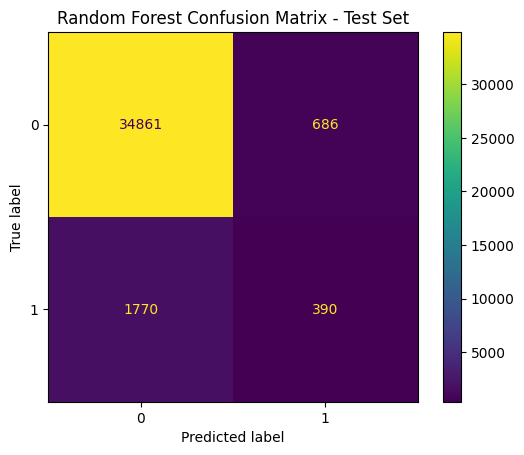

In [19]:
# Confusion matrix for test set
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_rf)
plt.title('Random Forest Confusion Matrix - Test Set')
plt.show()


In [20]:
# Feature Importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = vectorizer.get_feature_names_out()

In [21]:
# Print the top 20 features
print("Top 20 Important Features:")
for idx in indices[:20]:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

Top 20 Important Features:
if: 0.0587
NUMBER: 0.0560
return: 0.0479
void: 0.0365
int: 0.0335
const: 0.0313
static: 0.0301
else: 0.0273
struct: 0.0247
char: 0.0184
sizeof: 0.0179
for: 0.0175
bool: 0.0153
false: 0.0137
unsigned: 0.0135
while: 0.0127
long: 0.0125
true: 0.0120
this: 0.0117
goto: 0.0115
